In [1]:
team_codes = {
    
}  

BRAZIL CAMPEONATO
LAST GAMES UPDATE: 2024-06-17 (4 GAMES)
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
Test Accuracy: 1.48374


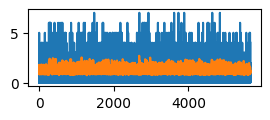

1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Cruzeiro | Atletico Paranaense (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Botafogo | Bragantino-SP (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Atletico Goianiense | Grêmio (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
   total_pred  spread_pred  total_score_pred       team_x
0    1.033525    -0.610395          2.793499       Cuiabá
1    1.559599     0.320852          2.925471  Corinthians


,total_pred,team_x
0,0.964659,Cuiabá
1,1.805866,Corinthians


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
   total_pred  spread_pred  total_score_pred     team_x
0    1.070517    -0.520544          2.748729  Juventude
1    1.507622     0.052783          2.920356   Flamengo


,total_pred,team_x
0,1.082738,Juventude
1,1.666211,Flamengo


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Internacional | Atletico Mineiro (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
   total_pred  spread_pred  total_score_pred         team_x
0    0.842417    -1.296539          2.926262  Vasco da Gama
1    1.963792     0.890807          3.032875          Bahia


,total_pred,team_x
0,0.505729,Vasco da Gama
1,2.415920,Bahia


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
   total_pred  spread_pred  total_score_pred     team_x
0    1.267024    -0.416505          2.922395  Fortaleza
1    1.317978    -0.342970          2.893089  Palmeiras


,total_pred,team_x
0,1.364192,Fortaleza
1,1.436079,Palmeiras


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Fluminense | Vitoria (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Sao Paulo | Criciuma (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Cuiabá | Bragantino-SP (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Vasco da Gama | Botafogo (single positional indexer is out-of-bounds)
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []
Fix teams: Atletico Mineir

,total_pred,team_x
0,1.024361,Fluminense
1,1.490906,Grêmio


KeyboardInterrupt: 

In [2]:
import warnings
warnings.filterwarnings('ignore')
from datetime import date, datetime
from dotenv import load_dotenv
from IPython.display import display
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytz
import random
import requests
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option('mode.use_inf_as_na', True)
load_dotenv()
API_KEY=os.getenv('ODDS_API_KEY')
DATE = date.today()
SIM = int(999e5)
SPORTS = []

all_sports = requests.get(f"https://api.the-odds-api.com/v4/sports/?apiKey={API_KEY}")
for item in all_sports.json():
    if 'soccer' in item['key']:
        SPORTS.append(item['key'])

try:
    os.remove('soccer_sims.csv')
except:
    pass

for SPORT in SPORTS:
    simulations = pd.DataFrame(columns=('sport','home_team','away_team','h_score','a_score','time'))

    sport = SPORT.replace('soccer_','').replace('_',' ').upper()
    print(sport)

    try:
        response = requests.get(f'https://api.the-odds-api.com/v4/sports/{SPORT}/events?apiKey={API_KEY}')
        games = response.json()

        for game in games:
            if game['home_team'] in team_codes:
                game['home_team'] = team_codes[game['home_team']]
            if game['away_team'] in team_codes:
                game['away_team'] = team_codes[game['away_team']]
    except:
        print('LEAGUE NOT AVAILABLE\n')
        continue

    for i, game in enumerate(games):
        df = pd.read_csv('data/soccer_games.csv', index_col=0)
        df = df.sort_values('date').reset_index(drop=True)
        del df['index_opp']

        if i == 0:
            last_update = df['date'].iloc[-1]
            num_games = len(df[df['date'] == str(last_update)]) // 2
            print(f"LAST GAMES UPDATE: {last_update} ({num_games} GAMES)")
        
        nulls = pd.isnull(df).sum()
        nulls = nulls[nulls > 100]
        valid_columns = df.columns[~df.columns.isin(nulls.index)]
        df = df[valid_columns].copy()
        df.fillna(value=0, inplace=True)
        
        def add_target(group):
            group['total_target'] = group['total'].shift(-1)
            group['spread_target'] = group['spread'].shift(-1)
            group['total_score_target'] = group['total_score'].shift(-1)
            return group
        
        df = df.groupby('team', group_keys=False).apply(add_target)
        df['total_target'][pd.isnull(df['total_target'])] = -0.1
        df['spread_target'][pd.isnull(df['spread_target'])] = -0.1
        df['total_score_target'][pd.isnull(df['total_score_target'])] = -0.1
        df['total_target'] = df['total_target'].astype(float, errors='ignore')
        df['spread_target'] = df['spread_target'].astype(float, errors='ignore')
        df['total_score_target'] = df['total_score_target'].astype(float, errors='ignore')
        
        removed_columns = ['date','team','team_opp','total_target','spread_target','total_score_target']
        selected_columns = df.columns[~df.columns.isin(removed_columns)]
        
        scaler = MinMaxScaler()
        df[selected_columns] = scaler.fit_transform(df[selected_columns])

        def shift_col(team, col_name):
            next_col = team[col_name].shift(-1)
            return next_col
        
        def add_col(df, col_name):
            return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
        
        df['home_next'] = add_col(df, 'home')
        df['team_opp_next'] = add_col(df, 'team_opp')
        df['date_next'] = add_col(df, 'date')
        
        home_team = game['home_team']
        away_team = game['away_team']
        
        null_indices = df[(df['team'] == home_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 1
            df.at[idx, 'team_opp_next'] = away_team
            df.at[idx, 'date_next'] = DATE
        null_indices = df[(df['team'] == away_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 0
            df.at[idx, 'team_opp_next'] = home_team
            df.at[idx, 'date_next'] = DATE

        df_rolling32 = df[list(selected_columns) + ['team']]
        
        def find_team_averages32(team):
            rolling = team.rolling(32, min_periods=1).mean(numeric_only=True)
            return rolling
        
        df_rolling32 = df_rolling32.groupby(['team'], group_keys=False).apply(find_team_averages32)
        rolling_cols32 = [f"{col}_32" for col in df_rolling32.columns]
        df_rolling32.columns = rolling_cols32

        df = pd.concat([df, df_rolling32], axis=1)
        
        df = df.dropna()
        
        full = df.merge(df[rolling_cols32 + 
                        ['team_opp_next', 'date_next', 'team']], 
                        left_on=['team', 'date_next'], 
                        right_on=['team_opp_next', 'date_next'])
        
        removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns
        selected_columns = full.columns[~full.columns.isin(removed_columns)]

        if i == 0:
            train_df = full[full['total_target']!=-0.1]
            X = train_df[selected_columns].values
            y_total = train_df['total_target'].values
            y_spread = train_df['spread_target'].values
            y_total_score = train_df['total_score_target'].values

            input_layer = Input(shape=(len(selected_columns),))

            layer1 = Dense(125, activation='relu')(input_layer)
            layer2 = Dense(25, activation='relu')(layer1)
            layer3 = Dense(5, activation='relu')(layer2)

            output_total = Dense(1, name='total_output')(layer3)
            output_spread = Dense(1, name='spread_output')(layer3)
            output_total_score = Dense(1, name='total_score_output')(layer3)
            model = Model(inputs=input_layer, outputs=[output_total, output_spread, output_total_score])
            model.compile(optimizer='adam', loss='mse')

            split = TimeSeriesSplit(n_splits=5)
            early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
            for train_index, test_index in split.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train_total, y_test_total = y_total[train_index], y_total[test_index]
                y_train_spread, y_test_spread = y_spread[train_index], y_spread[test_index]
                y_train_total_score, y_test_total_score = y_total_score[train_index], y_total_score[test_index]
                model.fit(X_train,
                        {'total_output': y_train_total, 'spread_output': y_train_spread, 'total_score_output': y_train_total_score},
                        epochs=125,
                        verbose=0,
                        callbacks=[early_stopping],
                        validation_data=(X_test, {'total_output': y_test_total, 'spread_output': y_test_spread, 'total_score_output': y_test_total_score}))
                
            test_df = train_df.iloc[test_index]
            test_predictions = model.predict(test_df[selected_columns])
            y_true = test_df['total_target'].values
            y_pred = test_predictions[0]
            mse = mean_squared_error(y_true, y_pred)
            print(f'Test Accuracy: {mse:.5f}')
            plt.figure(figsize=(3, 1))
            plt.plot(y_true)
            plt.plot(y_pred)
            plt.show()
            
            model.save('soccer_model.keras')
            
        model = tf.keras.models.load_model('soccer_model.keras')
        predictions = model.predict(full[selected_columns])
        full['total_pred'] = predictions[0]
        full['spread_pred'] = predictions[1]
        full['total_score_pred'] = predictions[2]

        scores = full[full['total_target'] == -0.1].reset_index()
        print(scores[['total_pred','spread_pred','total_score_pred','team_x']])

        try:
            if scores['total_pred'].iloc[0] > scores['total_pred'].iloc[1]:
                win = 0
                lose = 1
            else:
                win = 1
                lose = 0
            spread = scores['total_pred'].iloc[win] - scores['total_pred'].iloc[lose]
            total_score = scores['total_pred'].iloc[win] + scores['total_pred'].iloc[lose]

            spread += scores['spread_pred'].iloc[win]
            spread -= scores['spread_pred'].iloc[lose]
            spread /= math.sqrt(3)
            
            total_score += scores['total_score_pred'].iloc[win]
            total_score += scores['total_score_pred'].iloc[lose]
            total_score /= 3

            win_mean = (total_score + spread) / 2
            lose_mean = (total_score - spread) / 2
            if win_mean < 0:
                win_mean = 0
            if lose_mean < 0:
                lose_mean = 0
            win_team = scores['team_x'].iloc[win]
            lose_team = scores['team_x'].iloc[lose]

            win_score = np.mean(np.random.poisson(win_mean, SIM))
            lose_score = np.mean(np.random.poisson(lose_mean, SIM))

            scores['total_pred'].iloc[win] = win_score
            scores['total_pred'].iloc[lose] = lose_score
            display(scores[['total_pred', 'team_x']])

            time = datetime.strptime(game['commence_time'], '%Y-%m-%dT%H:%M:%S%z')
            eastern = pytz.timezone('US/Eastern')
            eastern_time = time.astimezone(eastern).strftime("%I:%M:%S%p")

            simulations.at[i, 'sport'] = sport

            simulations.at[i, 'home_team'] = home_team
            simulations.at[i, 'away_team'] = away_team
            simulations.at[i, 'time'] = eastern_time

            if win_team == home_team:
                simulations.at[i, 'h_score'] = win_mean
                simulations.at[i, 'a_score'] = lose_mean
            else:
                simulations.at[i, 'a_score'] = win_mean
                simulations.at[i, 'h_score'] = lose_mean
        except Exception as error:
            print(f"Fix teams: {home_team} | {away_team} ({error})")

    simulations = simulations.sort_values(by=['time', 'home_team']).reset_index(drop=True)
    display(simulations)

    simulations = simulations.dropna()
    simulations['h_score'], simulations['a_score'] = round(simulations['h_score'],3), round(simulations['a_score'],3)
    if not os.path.isfile('soccer_sims.csv'):
        simulations.to_csv('soccer_sims.csv', index=False)
    else:
        simulations.to_csv('soccer_sims.csv', mode='a', header=False, index=False)

os.remove('soccer_model.keras')